# Stock Price Prediction with LSTM




__Abstract__: This shows an example of implementing RNN model (in Tensorflow) to predict the stock price. Note that up until now there is no good model for stock prediction, and the model in this tutorial may not perform well.

For any machine learning problems, it is essential to follow these steps:
> 1. Problem definition.
> 2. Observing the raw data.
> 3. Defining the input data and machine learning model.
> 4. Obtain train/validation/test data.
> 5. Build model and train data.
> 6. Validate the predition results and model.

For this tutorial, I use the data of Dow Jones Industrial Average (DJI) as an example. The historical data can be downloaded from Yahoo Finance (https://finance.yahoo.com/quote/%5EDJI/history?p=%5EDJI). The data used for analysis is from 2006-01-01 to 2018-12-26. I have also placed the data file in this folder. 

As we want to predict the DJI price which is a time-series data, sequential RNN models can be used. The DJI data include __'Open'__, __'High'__, __'Low'__, __'Close'__ prices on each day. For simplicity, I use only __'Close'__ price, and LSTM model in this tutorial.

First, let us import the required modules:

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
from matplotlib import pyplot as plt

D:\software\Python36\anaconda\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Now let us load and observe the data:

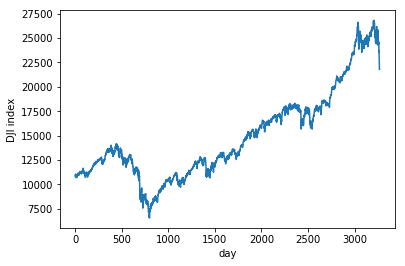

In [2]:
file_dir=os.getcwd()+'\DJI_data.csv'
read_data=pd.read_csv(file_dir)
#date=read_data['Date'].astype('|S')
data=read_data['Close'].values

plt.figure()
plt.plot(data)
plt.xlabel('day')
plt.ylabel('DJI index')
plt.show()

Raw DJI index data is not intuitive, instead, <font color=blue>day's gain %</font> can be used in the model. Below demonstrates the profile of <font color=blue>day's gain %</font>,

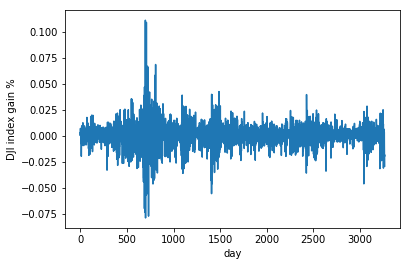

In [3]:
data=(data[1:]-data[:-1])/data[:-1]

plt.figure()
plt.plot(data)
plt.xlabel('day')
plt.ylabel('DJI index gain %')
plt.show()

We need to specify the input sequential data. The simplest input data is just a sequence of 'DJI index gain %' from above. Let us define the parameters for the LSTM model,

In [4]:
class LSTM_parameter:
    seq_length=5
    num_units=200
    num_layers=2
    batch_size=128
    learning_rate=0.001 # Note that a decaying learning rate may need to be used
    output_keep_prob=0.7
LSTM_param=LSTM_parameter()

Now let us create train/validation/test data, here a 80/10/10 split is used,

In [5]:
data=data[:(len(data)//LSTM_param.seq_length)*LSTM_param.seq_length]
reshaped_data=data.reshape((-1,1))
X=np.array([reshaped_data[i:i+LSTM_param.seq_length] for i in range(reshaped_data.shape[0]-LSTM_param.seq_length)])
Y=reshaped_data[LSTM_param.seq_length:]
train_size,validation_size=int(0.8*X.shape[0]),int(0.1*X.shape[0])
X_train,X_validation,X_test=X[:train_size],X[train_size:train_size+validation_size],X[train_size+validation_size:]
Y_train,Y_validation,Y_test=Y[:train_size],Y[train_size:train_size+validation_size],Y[train_size+validation_size:]

X_train.shape


(2608, 5, 1)

The next step is to create the LSTM model, first let us define the variables,

In [6]:
tf.reset_default_graph()

inputs=tf.placeholder(tf.float32,shape=[None,LSTM_param.seq_length,1])
outputs=tf.placeholder(tf.float32,shape=[None,1])    
learning_rate=tf.placeholder(tf.float32,None)

# we need parameters to transfer the last layer output to final response data


Then let us build the LSTM model, here a multi-layer basic LSTM model with a dropout of output neurons is implemented,

In [7]:
def LSTM_model(LSTM_param):
    model=[]
    for _ in range(LSTM_param.num_layers):
        cell=tf.nn.rnn_cell.LSTMCell(num_units=LSTM_param.num_units)
        dropout_cell=tf.nn.rnn_cell.DropoutWrapper(cell=cell,output_keep_prob=LSTM_param.output_keep_prob)
        model.append(dropout_cell)
    
    stacked_rnn_cell=tf.nn.rnn_cell.MultiRNNCell(model)
    return stacked_rnn_cell

lstm_model=LSTM_model(LSTM_param)

In order to obtain the prediction, we need to connect another layer to the last output of LSTM model. Below is the function to get the prediction,

In [8]:
def Model(lstm_model):
    lstm_output, _ = tf.nn.dynamic_rnn(cell=lstm_model,inputs=inputs,dtype=tf.float32)
    # note that the lstm output dimension is batch_size*seq_length*num_units*input x dimension, we need to reshape the output to obtain the last output of LSTM with the shape of batch_size*num_units*input x dimension:
    lstm_output=tf.transpose(lstm_output, [1,0,2])
    last = tf.gather(lstm_output, lstm_output.get_shape()[0] - 1)
    
    weight = tf.Variable(tf.truncated_normal([LSTM_param.num_units, 1]))
    bias = tf.Variable(tf.constant(0.1, shape=[1]))
    prediction = tf.matmul(last, weight) + bias
    return prediction

In [9]:
# define loss and optimizer
prediction=Model(lstm_model)

loss=tf.reduce_mean(tf.square(prediction-outputs))    
optimizer=tf.train.RMSPropOptimizer(LSTM_param.learning_rate)
minimize = optimizer.minimize(loss)

D:\software\Python36\anaconda\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [13]:
# start training
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    T_loss,V_loss=[],[] # used to record training and validation losses
    for epoch in range(X.shape[0]//LSTM_param.batch_size):
        batch_train_X=X_train[epoch*LSTM_param.batch_size:(epoch+1)*LSTM_param.batch_size]
        batch_train_Y=Y_train[epoch*LSTM_param.batch_size:(epoch+1)*LSTM_param.batch_size]
        train_feed={inputs:batch_train_X, outputs:batch_train_Y, learning_rate:LSTM_param.learning_rate}
        validation_feed={inputs:X_validation,outputs:Y_validation}
        train_loss,_=sess.run([loss,minimize],feed_dict=train_feed)
        validation_loss,pred_ratio=sess.run([loss,prediction],feed_dict=validation_feed)
        
        # add an early stop condition
        if V_loss and V_loss[-1]-validation_loss<1e-5:
            break
        T_loss.append(train_loss)
        V_loss.append(validation_loss)
    pred_test,pred_loss=sess.run([prediction,loss],feed_dict={inputs:X_test,outputs:Y_test})
    pred_test.shape

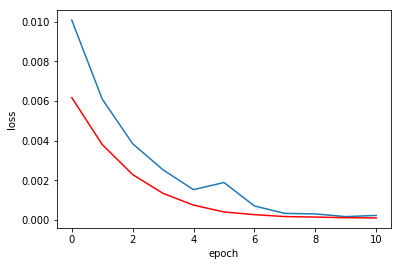

In [14]:
# plot training and validation losses
plt.figure(2)
plt.plot(T_loss)
plt.plot(V_loss,'r')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

0.00013346023

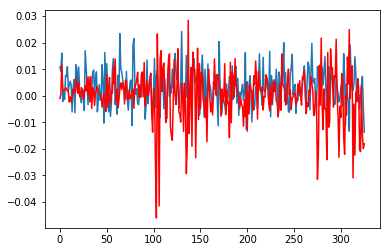

In [15]:
# result for test data, and comparison with true value
plt.figure(3)
plt.plot(pred_test)
plt.plot(Y_test,'r')

pred_loss

__Conclusion__: This tutorial shows an example of using RNN model to predict the stock price. It is essential to use the day's gain ratio as the input data, implementing raw index data (price) will yield bad result.